In [103]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

### Bring in data

In [124]:
df_raw = pd.read_csv('data/missoula_valley_monitored_wells.csv', parse_dates=['time'], index_col='time')
df_filled = pd.read_csv('data/missoula_valley_wells_imputed_qreg.csv')
df_pump = pd.read_csv('data/mso_monthly_pumping_rates.csv')
df_static = pd.read_csv('data/static_variables.csv')

### Heatmap of all data and gaps

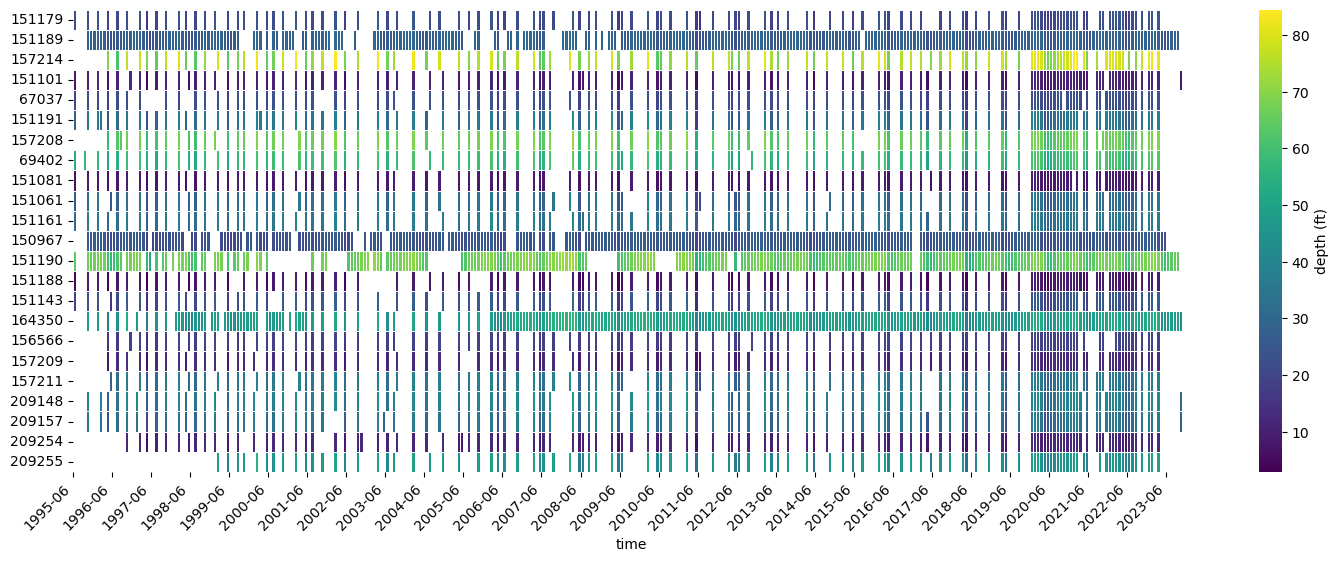

In [3]:
fig, ax = plt.subplots(figsize=(18, 6))
fig = sns.heatmap(df_raw.transpose(), 
                  cmap='viridis', 
                  cbar=True, 
                  linewidth=0.5, 
                  ax=ax, 
                  cbar_kws={'label': 'depth (ft)'})
xdates = df_raw.index.strftime('%Y-%m').sort_values().unique()
step = 12
ax.set_xticks(np.arange(0, len(xdates), step=step))
ax.set_xticklabels(xdates[::step], rotation=45, ha='right')
plt.show()

### Plot timeseries of all wells

In [4]:
df_melt = df_filled.drop(columns='Q').melt(id_vars='time')
df_melt['time'] = pd.to_datetime(df_melt['time'])

In [5]:
# Calculate trends and p-values and add to the DataFrame
df_trend = df_melt.copy()
df_trend['time'] = df_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)
def get_trend(x):
    """Define a function to fit a linear regression model and return the slope, 
    intercept, and p-value."""
    model = smf.ols('value ~ time', data=x).fit()
    return pd.Series([model.params['Intercept'], 
                      model.params['time'], 
                      model.pvalues['time']], 
                     index=['intercept', 'slope', 'p-value'])

# Group the data by the 'variable' column and apply the 'get_trend' function
trends = df_trend.groupby('variable').apply(get_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_trend = df_trend.join(trends, on='variable')

In [56]:
# Define a function to plot the data and the trendline
def plot_data_and_trendline(data, color):
    x = data['time']
    y = data['value']
    slope = data['slope'].iloc[0]
    intercept = data['intercept'].iloc[0]
    p_value = data['p-value'].iloc[0]
    
    # Convert the 'time' column to datetime for plotting
    x_datetime = pd.to_datetime(x, unit='s')
    
    # Plot the data
    plt.plot(x_datetime, y, color='gray', linewidth=0.75)
    
    # Set the color of the trendline based on the p-value
    trend_color = 'red' if p_value < 0.1 else 'black'

    # Add the p-value to the plot
    plt.text(0.15, 0.1, f'p-value: {p_value:.2f}', ha='left', va='top', transform=plt.gca().transAxes)

    # Plot the trendline
    plt.plot(x_datetime, intercept + slope * x, color=trend_color)

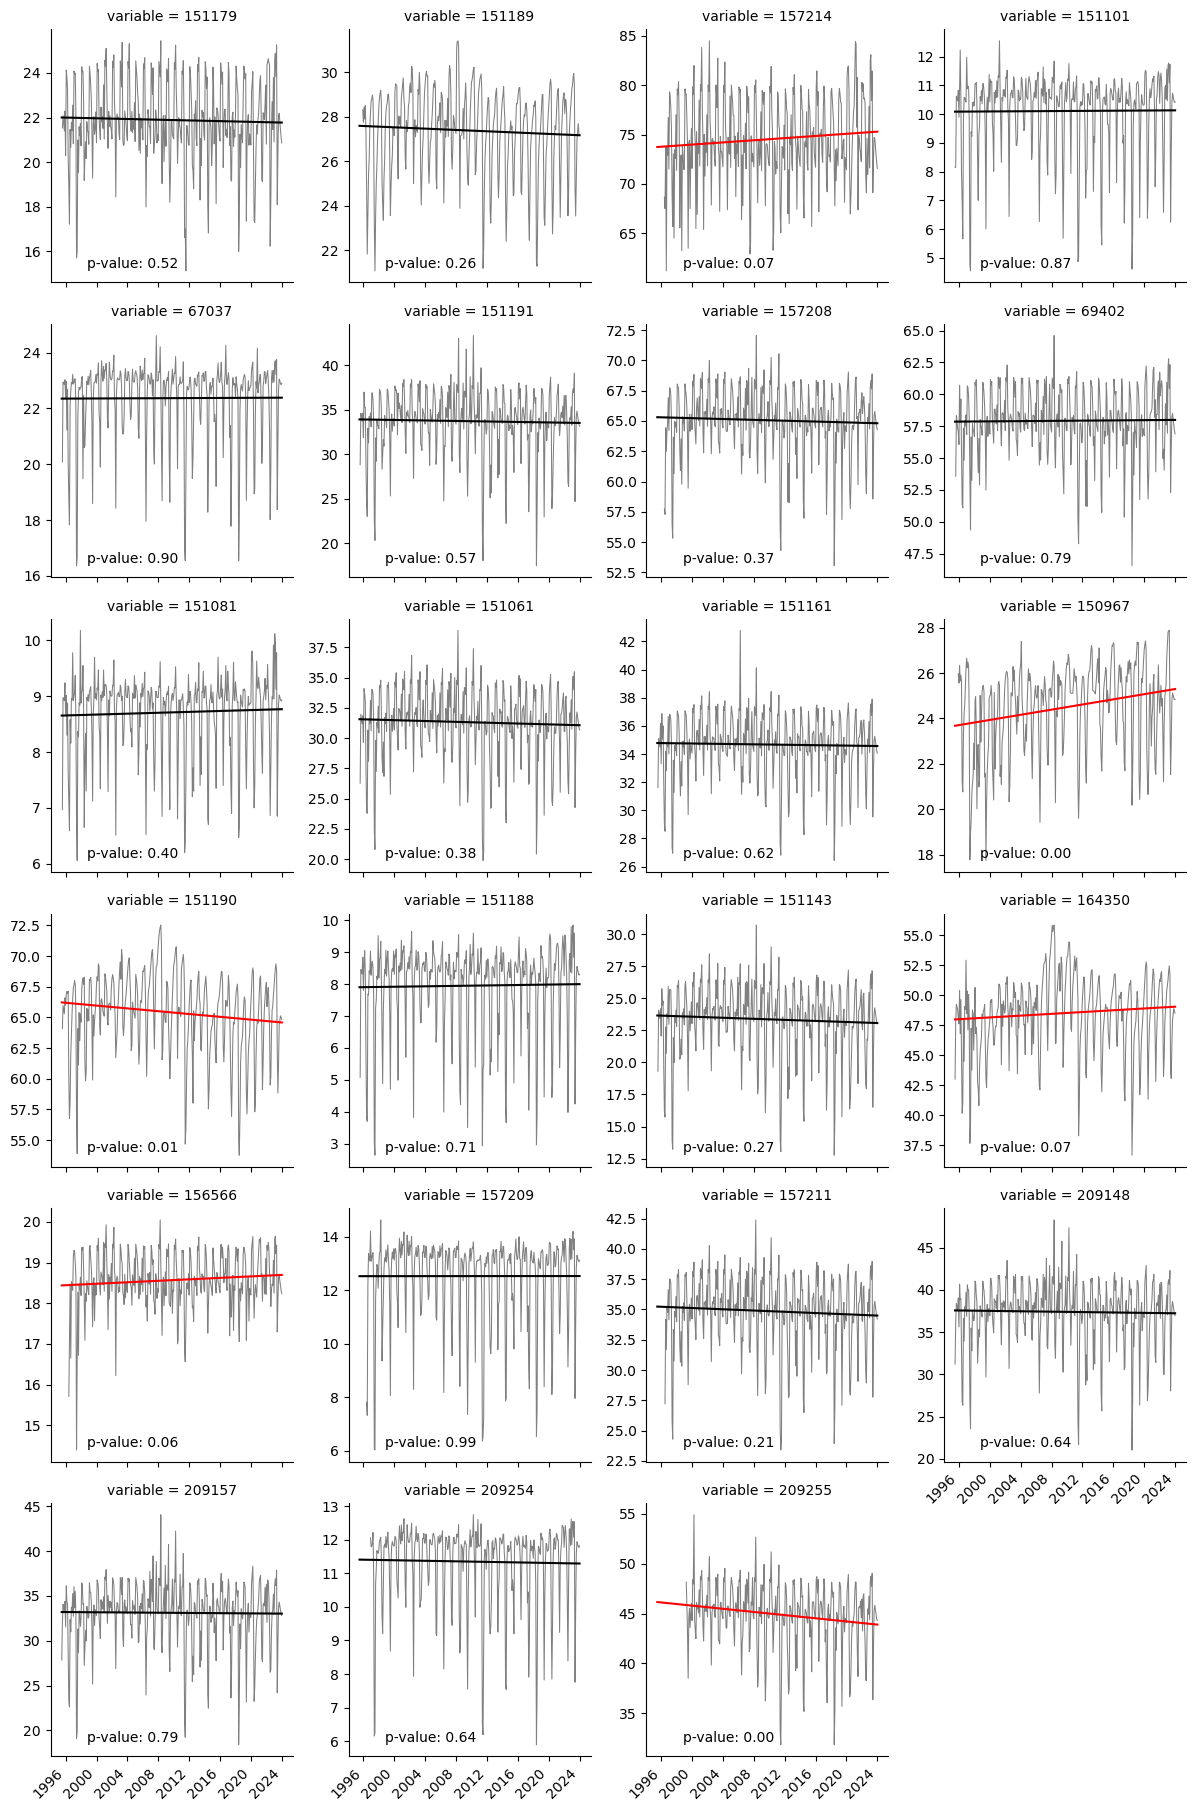

In [57]:
# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='variable', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(plot_data_and_trendline)

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

### Trends in interannual variability over time

In [58]:
# Define a function to plot the data and the quantile regression lines 
def plot_data_and_quantreg(data, color, quants=[0.1, 0.9]):
    data = data.dropna()
    x = np.arange(len(data['time'])) 
    y = data['value']
    data_df = pd.DataFrame({'x': x, 'y': y})
    
    # Quantile regresssion
    model = smf.quantreg('y ~ x', data_df)
    q1 = model.fit(q=quants[0])
    q2 = model.fit(q=quants[1])
    q3 = model.fit(q=0.5)
    
    # Convert the 'time' column to datetime for plotting
    x_datetime = pd.to_datetime(data['time'], unit='s')
    
    # Plot the data
    plt.plot(x_datetime, y, color='gray', linewidth=0.75)
    
    # Plot the trendline
    plt.plot(x_datetime, q1.fittedvalues, color='red')
    plt.plot(x_datetime, q2.fittedvalues, color='red')
    plt.plot(x_datetime, q3.fittedvalues, '--', color='black')

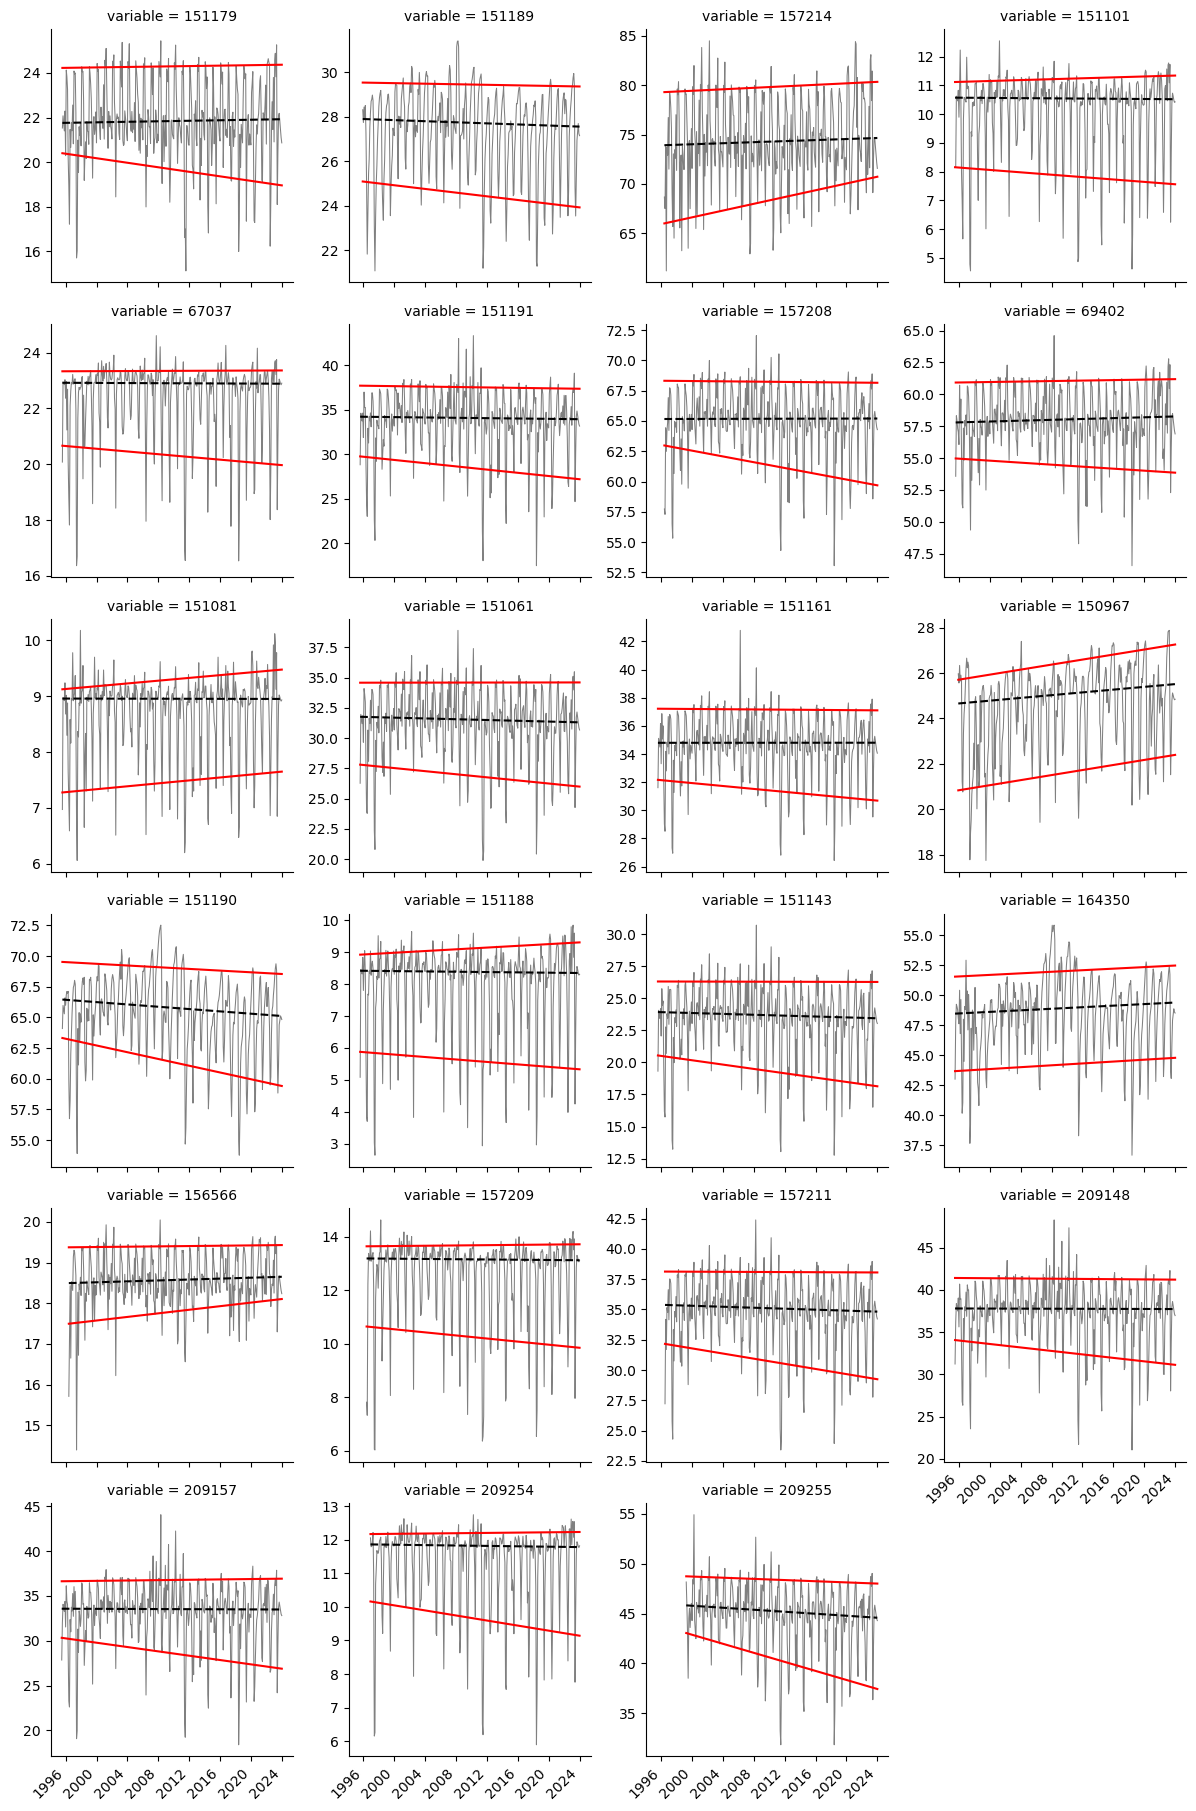

In [59]:
# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='variable', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(plot_data_and_quantreg)

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()


### Calculate correlation between slope and static variables

In [125]:
trends.index = trends.index.astype('int64')
df_stat = df_static.set_index('gwicid').merge(trends, right_on='variable', left_on='gwicid')
corrmat = df_stat.corr()
corrslope = corrmat['slope']
corrslope

latitude      0.132051
longitude     0.116647
altitude      0.346222
total_dept   -0.072622
swl           0.251780
cf_input     -0.078028
rs_input      0.055450
gc_input      0.306971
br_input      0.270370
outlet        0.049055
ksat_r        0.107650
intercept    -0.135373
slope         1.000000
p-value       0.029382
Name: slope, dtype: float64

### Plot slope on map

In [128]:
# Convert to GeoDataFrame
df_stat['geometry'] = [Point(xy) for xy in zip(df_stat.longitude, df_stat.latitude)]
gdf_stat = gpd.GeoDataFrame(df_stat, geometry='geometry', crs='EPSG:4326')

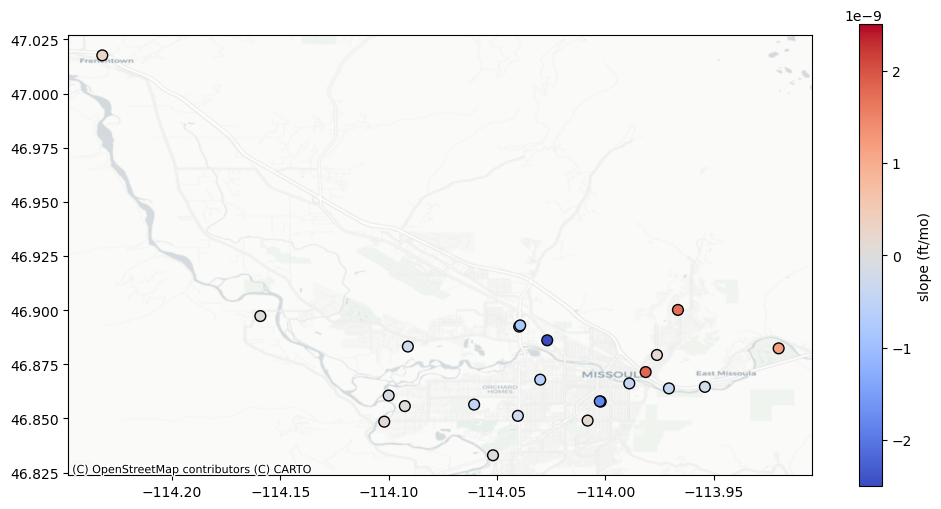

In [152]:
# Plot map
ax = gdf_stat.plot(figsize=(12, 6), 
                   column='slope', 
                   cmap='coolwarm', 
                   legend=True, 
                   vmin=-2.5e-09, 
                   vmax=2.5e-09,
                   edgecolor='black',
                   s=60)
ctx.add_basemap(ax, 
                crs=gdf_stat.crs, 
                source=ctx.providers.CartoDB.Positron,
                zoom=12)
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('slope (ft/mo)')
# ax.set_axis_off()
plt.show()